In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import igraph as ig
from scipy.sparse import vstack
from collections import Counter
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Datasets

Dataset; #graphs; #nodes; #nodes in giant comps

* MUTAG; 188; 3,371; 3,371
* BZR; 405; 14,479; 14,479
* NCI1; 4110; 122,747; 119,345
* NCI109; 4127; 122,494; 119,162
* IMDB-BINARY; 1000; 19,773; 19,773
* REDDIT-BINARY; 2000; 859,254; 851,133


In [2]:
dataset = 'REDDIT-BINARY'
datadir = '../Data/'+dataset+'/'+dataset

## read data from folder
fn_edges = datadir+'.edges'
fn_graph_id = datadir+'.graph_id'
fn_graph_label = datadir+'.graph_labels'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip())-1 for x in f.readlines()]

## build dictionary (node names are 1-based)
graph_dict = {(x+1):y for x,y in enumerate(sg_mem)}
for v in G.vs:
    v['graph'] = graph_dict[v['name']]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]
print('number of graphs:',len(graph_labels))


number of graphs: 2000


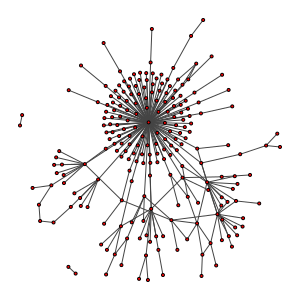

In [4]:
## subgraphs - example
sg_id = 0
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_id)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=3)
#, vertex_label=sg.vs['name']

### Method 1 - Expander-based Node Features

For every "small" graphs, compute some features derived from expansion properties of vertices.

See details in our blog post.

We can ignore the **node labels** if we want to compare with methods that rely only on the graph structure.


In [5]:
## by default, we ignore vertex labels.
def get_sg_features(sg, depth=7, add_features=False):
    F = []
    n = sg.vcount()
    m = sg.ecount()
    sg.vs['deg'] = sg.degree()
    Excess = np.array(sg.degree())-1
    Exp_q = (sum((Excess+1)*Excess)/(2*m))
    Var_q = sum((Excess+1)*Excess*Excess)/(2*m) - Exp_q**2
    if Var_q > 0:
        sg.vs['assort'] = Excess*(Excess+1)*(np.array([np.mean([Excess[j] for j in sg.neighbors(i)]) for i in range(n)]) - Exp_q)/(2*m*Var_q)
    else:
        sg.vs['assort'] = 1
    
    if add_features:
        features = [np.array(sg.degree()),
                    sg.transitivity_local_undirected(mode='zero'),
                    np.array(sg.betweenness())/n**2,
                    sg.pagerank(),
                    np.array(sg.coreness()),
                    sg.vs['assort']
                   ] 
        for j in range(len(features)):
            F.append(features[j])
    ## now consider increasing depths
    for i in range(depth):
        current = sg.neighborhood_size(order=i+1)
        ## expanding proportion
        F.append([j/n for j in current])
        ## relative expanding properties
        if i>0:
            F.append([j / k for j, k in zip(current, previous)])
        previous = current
        ## aggregate of other features at this depth
        if add_features:
            sg_nei = sg.neighborhood(order=i+1)
            for j in range(len(features)):
                F.append([np.mean([features[j][k] for k in x]) for x in sg_nei])
    F = np.array(F).transpose()
    return F

## WL-like message passing

* also added an option to return only a sample of the node feature vectors

In [6]:
## WL - like
def get_sg_features_wl(sg, depth=7, add_features=False, sample=1.0, min_sample_size=5):

    F = []
    n = sg.vcount()
    m = sg.ecount()
    #sg.vs['deg'] = sg.degree()
    Excess = np.array(sg.degree())-1
    Exp_q = (sum((Excess+1)*Excess)/(2*m))
    Var_q = sum((Excess+1)*Excess*Excess)/(2*m) - Exp_q**2
    if Var_q > 0:
        sg.vs['assort'] = Excess*(Excess+1)*(np.array([np.mean([Excess[j] for j in sg.neighbors(i)]) for i in range(n)]) - Exp_q)/(2*m*Var_q)
    else:
        sg.vs['assort'] = 1

    if True:
        features = [np.array(sg.degree()),
                    sg.transitivity_local_undirected(mode='zero'),
                    np.array(sg.betweenness())/n**2,
                    sg.pagerank(),
                    np.array(sg.coreness()),
                    sg.vs['assort']
                   ] 
        F = np.array(features).transpose()
    ## store graph features as arrays
    sg.vs['f'] = [x for x in F]

    ## recursion
    sg_nei = sg.neighborhood(order=1)

    for rep in range(depth):
        new_f = np.array([np.mean(np.array([sg.vs[i]['f'] for i in sg_nei[j]]), axis=0) for j in range(n)])
        sg.vs['f'] = [x for x in new_f]
        F = np.concatenate((F,new_f),axis=1)
        current = sg.neighborhood_size(order=rep+1)
        ## expanding proportion
        E = np.array([j/n for j in current]).reshape(n,1)
        F = np.concatenate((F,E),axis=1)
        ## relative expanding properties
        if rep>0:
            E = np.array([j / k for j, k in zip(current, previous)]).reshape(n,1)
            F = np.concatenate((F,E),axis=1)
        previous = current
    if sample<1:
        s = F.shape[0]
        if min_sample_size > s:
            min_sample_size = s
        sample_size = max(int(np.ceil(s*sample)), min_sample_size)
        r = np.random.choice(s, sample_size, replace=False)
        F =  F[r]
    return F


### Input format

* **node_features**: array (length = number of graphs) of arrays of size "number of vertices x number of features"

Below, we prepare the data we have in this format.

In [7]:
%%time
## feature for every graph - this is the slowest part
node_features = []
rows = []
ctr = 1
for i in list(set(G.vs['graph'])):
    ## we keep the giant component for each small graph
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist()).connected_components().giant()
    F = get_sg_features_wl(sg, depth=7, add_features=True, sample=.5) ## options: KL-like or not, sample or not
    node_features.append(F) 
    rows.extend(np.repeat(i,F.shape[0]))
    ctr += 1
    if ctr % 250 == 0:
        print(ctr)
node_features = np.array(node_features, dtype=object)


250
500
750
1000
1250
1500
1750
2000
CPU times: user 10min 33s, sys: 339 ms, total: 10min 34s
Wall time: 4min 42s


### first step - build (graphs x nodes) sparse incidence matrix


In [8]:
## consider all node's feature vectors
node_vectors = np.vstack(node_features)

In [9]:
%%time
## incidence - this is quite fast
n = len(rows)
cols = np.arange(n)
incidence_matrix = scipy.sparse.csr_matrix((np.repeat(1.0,n).astype(np.float32), (rows, cols)))
incidence_matrix

CPU times: user 47.3 ms, sys: 27 µs, total: 47.3 ms
Wall time: 46.8 ms


<2000x426049 sparse matrix of type '<class 'numpy.float32'>'
	with 426049 stored elements in Compressed Sparse Row format>

### second step - embed graphs via Wasserstein's

In [10]:
%%time
## embed the graphs via distributions over node vectors - also fast
graphs_embed = vectorizers.ApproximateWassersteinVectorizer(
#     normalization_power=0.66,
    normalization_power=1.0,
    random_state=123,
).fit_transform(incidence_matrix, vectors=node_vectors)
graphs_embed.shape

CPU times: user 1.26 s, sys: 1.79 s, total: 3.05 s
Wall time: 79.4 ms


(2000, 61)

In [11]:
%%time
## same as above, but with normalized vectors
node_vectors_norm = normalize(node_vectors, axis=1, norm='l1')
graphs_embed_norm = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    random_state=42,
).fit_transform(incidence_matrix, vectors=node_vectors_norm)
graphs_embed_norm.shape

CPU times: user 1.66 s, sys: 4.93 s, total: 6.59 s
Wall time: 238 ms


(2000, 61)

In [12]:
##save results
import pickle
fn = 'Results/expander_'+dataset+'.pkl'
with open(fn,'wb') as fp:
    pickle.dump( (graphs_embed,
                  graphs_embed_norm,
#                   graphs_embed_expand,
#                   graphs_embed_expand_svd
                 ), 
                  fp
    )
